# A Study on Generalized Item Based Filtering using SVD

In [3]:
import pandas as pd 
import numpy as np
import csv
import math
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


## Purpose

Our proposed algorithm for the following code utlized the first experiment in the article. In brief the SVD was calculated as follows:
* Data Normalization:   
    *  The first step in the process was the normalize the data, this was accomplished by taking the data as whole, and filling in all the NA values with the Mean value of that specific movie. This was to eliminate the sparcity and to create a more complete dataset. It was then necessary to further normalize the data by finding the mean_center, which was computed by taking rating and subtracting the mean of each individual user. 
    * Following the Normalization process, the SVD was calculated using Numpy's built in formula. It was here that we calculated the approximate decomposite matrices. Using a formula, we ensured we could take the desired k-value for the reduced matrix decomposition, and compute a new R_Red matrix from the relevant reduced elements. 
    * Finally, the full predicted matrix was calculated using Cosine similarities on an Item-Item basis. Taking the nearest neighbors (using a formula obtained from Padebetttu et al [1]), we calculated the relative similarity and used that formula to add it back to the calculated user_mean that we initially substracted out. 

### Data Collection and Cleaning

In [4]:
#Data file containing ratings data
f = open("data/u.data")
text = csv.reader(f, delimiter = "\t")
ratings = list(text)

#Data containing Item Data (Content)
f = open("data/u.item")
text = csv.reader(f, delimiter = "|")
item = list(text)

ratings_pd = pd.DataFrame(ratings, columns = ["user_id","movie_id", "rating","timestamp"])
ratings_pd = ratings_pd.drop(["timestamp"], 1)

items_pd = pd.DataFrame(item, columns = ["movie_id","title","release","video_release","IMDB",
                                         "unknown","Action","Adventure","Animation","Child",
                                         "Comedy","Crime","Doc","Drama","Fantasy","Film-Noir",
                                         "Horror","Musical","Mystery","Romance","Sci-Fi", 
                                         "Thriller","War", "Western"])

items_pd = items_pd.drop(["movie_id","release","video_release","IMDB"], 1)


#Creating Content and Rating dataframes
items = items_pd.set_index(["title"])

movies = ratings_pd.pivot(index = "user_id", columns = "movie_id", values = "rating")

movies_test = movies
movies_test = movies.apply(pd.to_numeric, errors='coerce')
movies = movies.apply(pd.to_numeric, errors='coerce')
movies_int = np.array(movies)
np.nan_to_num(movies_int)

# Borrowed some code here from Padebetttu et. al. -DATA643- Project 2
user_mean = movies.T.mean(skipna=True)
item_mean = movies.mean(skipna=True)
movies = movies.apply(lambda x: x.fillna(x.mean(skipna = True)),axis=1)
movies_mean = movies.apply(lambda x: x-x.mean(), axis = 0).round(5)


### Using SVD to Determine an appropriate *k* Value

In [5]:
#Using SVD to find 
movies_np = np.array(movies_mean)
movies_np = movies_np.astype(float)


def svd_red(movies_mean,n):
    U1, s1, V1 = np.linalg.svd(movies_mean, full_matrices=True)
    k = np.zeros((len(s1),len(s1)),float)
    np.fill_diagonal(k,s1)
    k = k[:n,:n]
    k = np.sqrt(k)
    U2 = U1[:,:n]
    V2 =V1[:,:n].T
    Uk = np.dot(U2,k.T)
    Vk = np.dot(k,V2)
    R_red = np.dot(Uk,Vk)
    return R_red, Uk, Vk

def pred_item(movies_mean,n):
    R_red, Uk, Vk = svd_red(movies_mean,n)
    item_similarity = 1 - pairwise_distances(Vk.T, metric='cosine')
    pred = R_red.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])  
    final_pred = pred.T
    final_pred += user_mean
    final_pred = final_pred.T
    return final_pred


Using the above code we are able to find a prediction based on the Item-Item Collaborative Filter using SVD. To test various values of K to determine if the k by k reduced matrix size greatly influence the Error, we can calculate the Root Mean Square Error over several changes in k. 

In [6]:
RMSE = []

k = [1,2,3,4,5,10,20,30,40,50,100,200,300,400,500]

for i in k:
    pred = pred_item(movies_mean, i)
    y = mean_squared_error(movies_int[np.where(movies_int >0)], pred[np.where(movies_int >0)])   
    RMSE.append(math.sqrt(y))

Ploting the Error gives us a better representation of the error that betweeen the actual predicted values: 

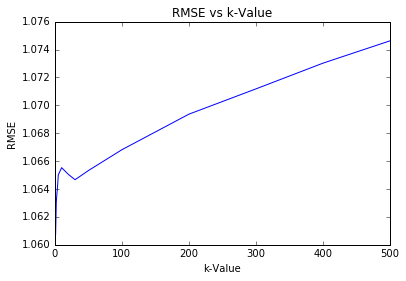

In [7]:
%matplotlib inline
plt.plot(k, RMSE)
plt.title("RMSE vs k-Value")
plt.ylabel('RMSE')
plt.xlabel("k-Value")
plt.show()

From our investigation, the k-value makes very little difference in the overall error, as it is very likely that vast number of data points will not result in a significant difference. However the above graph allows for us to pick a suitable k value to minimize computation will still maintain an accuracy. As you can see from our graph, to minimize the error, the best overal values to pick are in the 50 to 60 range. This ensure both that the SVD isn't overfitting that data (which we see in the increase in RMSE over the increase in K), and isn's too small to miss any latent relational data [2] On a side note: very low k values actually produced error ratings much lower than the choosen k = 50 for the remainder of the project. It can be assumed that the SVD actually over simplifies at those low values producing lower error but less accurate predictions. We will test this by checking the values of a small sample from each. 

In [8]:
index = movies.index.tolist()
columns = list(movies.columns.values)
pred = pred_item(movies_mean, 50)
Pred_pd = pd.DataFrame(pred, index = index, columns=columns)

i = ['56','64','71','94','102','118','173','196','928','651','514','483','432','404']
movies_sm = movies_test.loc[i,:]
Pred_sm = Pred_pd.loc[i,:]

l = ['13','201','222','234','246','268','269','276','655','95','194']
movies_sm = movies_sm.loc[:,l]
Pred_sm = Pred_sm.loc[:,l]


In [9]:
movies_sm

movie_id,13,201,222,234,246,268,269,276,655,95,194
user_id,,,,,,,,,,,
56,NaN,4,5,4,NaN,NaN,NaN,NaN,4,4,5
64,NaN,NaN,4,4,NaN,NaN,5,NaN,4,4,5
71,NaN,NaN,3,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
94,NaN,4,3,5,4,4,NaN,NaN,4,NaN,4
102,3,2,3,3,NaN,NaN,2,NaN,3,4,3
118,NaN,5,NaN,5,NaN,NaN,NaN,NaN,5,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,4,4,NaN,NaN,NaN,NaN
196,2,NaN,NaN,NaN,NaN,NaN,3,NaN,5,NaN,NaN
928,NaN,NaN,NaN,NaN,5,5,5,5,NaN,NaN,NaN


In [10]:
Pred_sm

,13,201,222,234,246,268,269,276,655,95,194
56,3.705890,3.706253,3.688925,3.614217,3.700699,3.637083,3.707786,3.658499,3.591617,3.636757,3.668293
64,3.563734,3.580158,3.597884,3.552802,3.593489,3.548204,3.605790,3.551261,3.592060,3.609608,3.566660
71,3.948515,3.977349,3.953379,3.727964,3.993754,3.671309,3.961852,3.868424,3.768933,3.846156,3.957671
94,3.791240,3.771937,3.706713,3.548481,3.720132,3.707862,3.795395,3.642575,3.582870,3.707394,3.654438
102,1.852006,1.707011,1.839114,2.947035,1.615833,3.185128,1.693271,2.178361,2.740430,2.321122,1.840288
118,5.507819,5.679627,5.542454,4.300141,5.786972,4.025064,5.661402,5.127780,4.482847,5.016225,5.521944
173,4.697703,4.790550,4.699225,4.004312,4.857738,3.850431,4.792971,4.484341,4.112894,4.402015,4.712521
196,3.634648,3.644748,3.627322,3.623875,3.647674,3.591890,3.628811,3.636393,3.605728,3.637441,3.648024
928,5.563090,5.719563,5.575815,4.334273,5.835227,4.041204,5.704602,5.172854,4.523538,5.049504,5.575761
651,3.033550,2.994898,3.022378,3.399256,2.979808,3.451665,3.010760,3.171679,3.338330,3.185881,3.054156


In [11]:
pred_sm = np.array(Pred_sm)
movies_sm = np.array(movies_sm)
movies_sm = np.nan_to_num(movies_sm)

movies_sm
y = mean_squared_error(movies_sm[np.where(movies_sm >0)], pred_sm[np.where(movies_sm >0)])   
math.sqrt(y)

0.8246501061967796

In [12]:
items = items_pd.set_index(["title"])


### References

[2]Vozalis M., Margaritis K.; *Applying SVD on Generalized Item-based Filtering* International Journal of Computer Science & Applications 2006; Vol.3 Is.3, pp 27- 51 2006 http://www.tmrfindia.org/ijcsa/v3i34.pdf

[3]F. Maxwell Harper and Joseph A. Konstan. 2015. *The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4, Article 19 (December 2015), 19 pages. http://dx.doi.org/10.1145/2827872 http://grouplens.org/datasets/movielens/